## Faster R-CNN的极简实现
### https://github.com/chenyuntc/simple-faster-rcnn-pytorch/blob/master/demo.ipynb


In [5]:
from torch import nn
from torchvision.models import vgg16
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from tqdm import tqdm


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda:1")  #torch.device代表将torch.Tensor分配到的设备的对象

#生成VGG16基础网络
def base_vgg16():
    model = vgg16(pretrained=True)
    features = list(model.features)[:30]
    classifier = model.classifier
    classifier = list(classifier)
    
    del classifier[6]
    classifier = nn.Sequential(*classifier)
    for layer in features[:10]:
        #print(layer)
        for p in layer.parameters():
            p.requires_grad = False
    print(nn.Sequential(*features))
    print(classifier)        
    return nn.Sequential(*features), classifier


base_vgg16()

In [7]:
#vgg16基础网络
def decom_vgg16():
    '''生成vgg16基础网络，并返回其卷积和全连接部分'''
    vgg = models.vgg16(pretrained=True, progress=True)
    #删去卷积最后的池化层
    extractor = nn.Sequential(*list(vgg.features)[:-1])
    classifier = vgg.classifier
    #删去全连接最后的线性层，为了定制输出
    del classifier[6]
    
    #冻结前4层的梯度，加快训练过程
    for i,layer in enumerate(extractor):
        if i>=10:
            break
        if isinstance(layer,torch.nn.modules.conv.Conv2d):
            for p in layer.parameters():
                p.requires_grad = False
    #print(extractor)
    #print(classifier)
    return extractor, classifier

In [8]:
decom_vgg16()

(Sequential(
   (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): ReLU(inplace)
   (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (3): ReLU(inplace)
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (6): ReLU(inplace)
   (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (8): ReLU(inplace)
   (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (15): ReLU(inplace)
   (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (17): Conv2d(256, 512, kernel_size=(3, 3), strid

## RPN模块
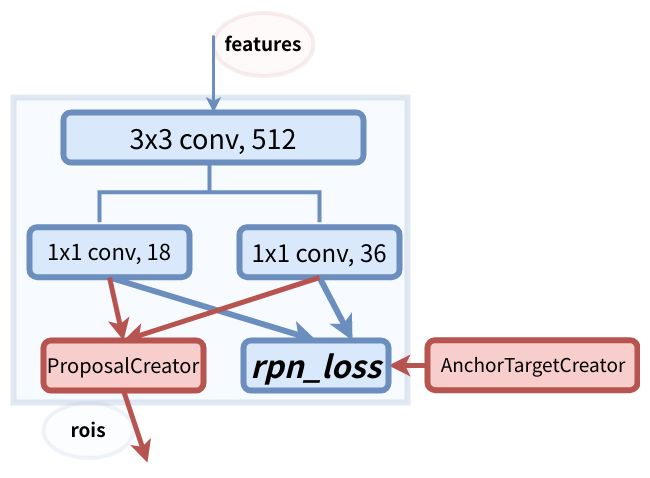

In [9]:
#from lib.generate_anchors import enumerate_shifted_anchor
from lib.creator_tool import ProposalCreator
from lib.generate_anchors import generate_anchor_base
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from tqdm import tqdm

In [10]:
def normal_init(m, mean, stddev, truncated=False):
    """
    权重初始化: 截断正态或随机正态.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

In [11]:
def enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    '''产生后续的先验框:
    
    参数:
    
        anchor_base(R, 4):初始预选框
        feat_stride（int）:特征图上移动一个像素对应于原图移动的像素
        height, width：特征图尺寸
    返回：
        ~numpy.ndarray
        一个数组，形状为(K*R, 4)，k为特征图总像素
    '''
    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)#
    shift = np.stack((shift_x.ravel(), shift_y.ravel(),shift_x.ravel(), shift_y.ravel()), axis=1)#  .ravel() 将数组展平输出沿y轴拼接的数组
    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + shift.reshape((1, K, 4)).transpose((1, 0, 2))
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor


In [12]:

class RegionProposalNetwork(nn.Module):
    """ Faster R-CNN中的区域提议网络（RPN）.

    参数:
        in_channels (int): 输入通道数.
        mid_channels (int): 中间层通道数.
        ratios (list of floats): 先验框宽高比列表
        anchor_scales (list of numbers): 先验框尺寸列表
        feat_stride (int): 特征图上移动一个像素对应于原图移动的像素
        proposal_creator_params=dict()
    """

    def __init__(self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],anchor_scales=[8, 16, 32], feat_stride=16,
                 proposal_creator_params=dict(),):
        super(RegionProposalNetwork, self).__init__()#等同于运行dengnn.Module.__init__(self)父类
        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)# 调用generate_anchor_base（）函数，
        #生成左上角9个anchor_base
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(self, **proposal_creator_params)#为Fast-RCNN也即检测网络提供2000个训练样本,极大值抑制
        n_anchor = self.anchor_base.shape[0]
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)
    def forward(self, x, img_size, scale=1.):
        """RPN前向.

        参数:
            x (~torch.autograd.Variable): 传入的特征图(N, C, H, W)`.
            img_size (tuple of ints): 放缩之后的图像高宽
            scale (float): 对比原图的放缩比例.

        返回:
            (~torch.autograd.Variable, ~torch.autograd.Variable, array, array, array):.

            * **rpn_locs**: 预测框的偏移缩放量，形状为(N, H*W*A, 4)`.
            * **rpn_scores**:预测框的分类置信度.形状为(N, H*W*A, 2)`.
            * **crois**: 输出所有的roi
            * **anchor**: 所有先验框的尺寸(H *W* A, 4)`.

        """
        n, _, hh, ww = x.shape
        #n是batchsize大小
        #print ('self.anchor_base',self.anchor_base)
        #print (self.anchor_base.shape)
         # 所有特征图上9种锚点的坐标
        anchor = enumerate_shifted_anchor(np.array(self.anchor_base),self.feat_stride, hh, ww)
        # print anchor动态获取Faster RCNN首先是支持输入任意大小的图片的，
        #进入网络之前对图片进行了规整化尺度的设定，如可设定图像短边不超过600，图像长边不超过1000，
        #我们可以假定M*N=1000*600（如果图片少于该尺寸，可以边缘补0，即图像会有黑色边缘）
        #print anchor.shape
        n_anchor = anchor.shape[0] // (hh * ww)#一个中心点anchor的数量，return (K*A, 4) ， K = hh*ww  ，K约为20000
        #anchor = anchor.reshape((K * A, 4)).astype(np.float32)
        h = F.relu(self.conv1(x))
        rpn_locs = self.loc(h)
        # UNNOTE: check whether need contiguous
        # A: Yes，contiguous保持内存连续可以加快执行速度，reshape函数似乎可以更好地完成这个工作
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)#返回具有相同数据但大小不同的新张量
        #permute：将tensor的维度换位，
        #有些tensor并不是占用一整块内存，而是由不同的数据块组成，而tensor的view()操作依赖于内存是整块的，
        #这时只需要执行contiguous()这个函数，把tensor变成在内存中连续分布的形式。
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, hh, ww, n_anchor, 2), dim=4)
        #对n维输入张量运用Softmax函数，将张量的每个元素缩放到（0,1）区间且和为1，输出与输入相同尺寸和形状的张量器
        #dim:指明维度，dim=0表示按列计算；dim=1表示按行计算,4表示维度按照
        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)
        # 经过nms(极大值抑制)获得的roi
        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(
                rpn_locs[i].cpu().data.numpy(),
                rpn_fg_scores[i].cpu().data.numpy(),
                anchor, img_size,
                scale=scale)
            batch_index = i * np.ones((len(roi),), dtype=np.int32)
            rois.append(roi)
            roi_indices.append(batch_index)
        # 将list转为numpy格式，
        rois = np.concatenate(rois, axis=0)
        roi_indices = np.concatenate(roi_indices, axis=0)
        #printf(roi.shape)
        crois = np.zeros((rois.shape[0],rois.shape[1]+1), dtype = np.float32)
        crois[:,0] = roi_indices
        crois[:,1:] = rois
        
        return rpn_locs, rpn_scores, crois, anchor
    



## ROIHead模块
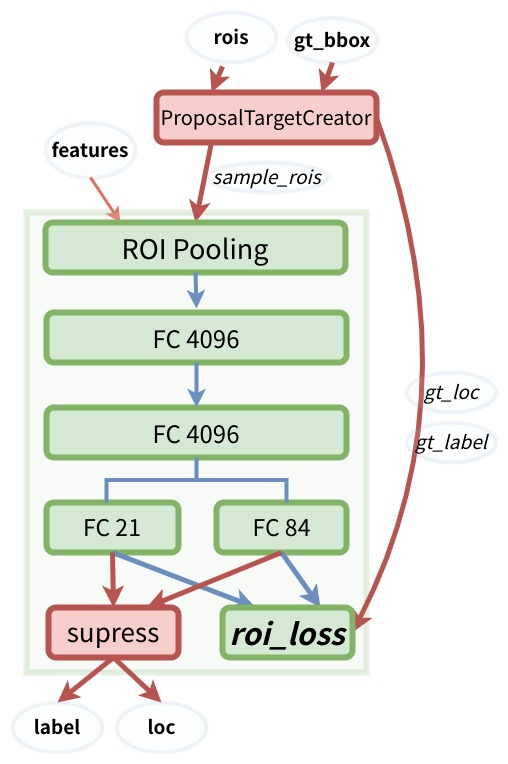

In [13]:
from torchvision.ops import RoIAlign#插值改进

def totensor(data, cuda=True):
    '''转换numpy到Tensor的一些流程集合'''
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    if isinstance(data, torch.Tensor):
        tensor = data.detach()
    if cuda:
        tensor = tensor.to(device)
    return tensor

class VGG16RoIHead(nn.Module):
    """输出在RIOS上的分类和回归执信度.
    
    Args:
        n_class (int): 总类别数（包含背景）.
        roi_size (touple): RoI-pooling之后的roi尺寸.
        spatial_scale (float): roi的比例调整大小.将输入坐标映射到框坐标的缩放因子
        classifier (nn.Module): 从vgg16得来的两层线性层

    """

    def __init__(self, n_class, roi_size, spatial_scale,classifier):

        super(VGG16RoIHead, self).__init__()

        self.classifier = classifier
        self.cls_loc = nn.Linear(4096, n_class * 4)
        self.score = nn.Linear(4096, n_class)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.n_class = n_class
        self.roi_size = roi_size
        self.spatial_scale = spatial_scale
        self.roi = RoIAlign(self.roi_size, self.spatial_scale, 1)#池化操作 output (Tensor[K, C, output_size[0], output_size[1]])
        #def __init__(self, output_size, spatial_scale, sampling_ratio):

    def forward(self, x, rois):
        """
        假设输入batch有N个样本.

        参数:
            x (Variable): 4维图片.
            rois (Tensor): rois（N,5）

        """
        # 避免假使 roi_indices is  ndarray
        rois = totensor(rois).float()        
        pool = self.roi(x, rois)
        pool = pool.view(pool.size(0), -1)
        fc7 = self.classifier(pool)
        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        return roi_cls_locs, roi_scores

## 定义Faster-Rcnn类结构，适用于整个预测过程比如优化器学习率等

In [14]:
from lib.array_tool import totensor, tonumpy
from lib.bbox_tool import loc2bbox
from torchvision.ops import nms

def nograd(f):
    '''装饰器，在预测中不追踪梯度'''
    def new_f(*args,**kwargs):
        with torch.no_grad():
            return f(*args,**kwargs)
    return new_f

class FasterRCNN(nn.Module):
    """Faster R-CNN基类.
    
    参数:
        extractor (nn.Module): 输入B、C、H、W图片返回特征图的基础模型.
        rpn (nn.Module): RPN网络模型.
        head (nn.Module):输入B、C、H、W变量的RoIs,返回回归和分类置信度的网络模型.
        loc_normalize_mean (tuple of four floats): 位置回归的均值估计.
        loc_normalize_std (tupler of four floats):位置回归的方差估计.

    """
    def __init__(self, extractor, rpn, head,
                loc_normalize_mean = (0., 0., 0., 0.),
                loc_normalize_std = (0.1, 0.1, 0.2, 0.2)):
        super(FasterRCNN, self).__init__()
        self.extractor = extractor
        self.rpn = rpn
        self.head = head

        # mean and std
        self.loc_normalize_mean = loc_normalize_mean
        self.loc_normalize_std = loc_normalize_std
        self.nms_thresh = 0.3
        self.score_thresh = 0.05
        
    @property
    def n_class(self):
        # 所有的类别总数，包含背景
        return self.head.n_class
    
    def forward(self, x, scale=1.):
        """Faster R-CNN前向.

        参数:
            x (autograd.Variable): B、C、H、W 4D 图片变量.
            scale (float): 预处理时对原始图片的缩放.

        返回:
            Variable, Variable, array:

            * **roi_cls_locs**: 所有roi的偏置缩放 (R', (L + 1) \\times 4)`.
            * **roi_scores**: 所有roi的分类预测 (R', L + 1)`.
            * **rois**: RPN提出的rois(R', 5)`.
        """
        img_size = x.shape[2:]
        h = self.extractor(x)
        
        rpn_loss, rpn_scores, crois, anchors = self.rpn(h, img_size, scale)
        
        roi_cls_locs, roi_scores = self.head(h, crois)
        
        return roi_cls_locs, roi_scores, crois
        
    def _suppress(self, raw_cls_bbox, raw_prob):
        '''
        预测过程中执行的一系列操作，包括
            1.预测数据筛选，去除背景类
            2.执行极大值抑制，保留部分框
            3.数据的变形结合等
        
        参数：
            raw_cls_bbox(tensor):roihead给出的预测框回归（N,84）
            raw_prob（tensor）:roihead给出的分类执信(N,21)
        '''
        bbox = list()
        label = list()
        score = list()
        # skip cls_id = 0 because it is the background class
        for l in range(1, self.n_class):
            cls_bbox_l = raw_cls_bbox.reshape((-1, self.n_class, 4))[:, l, :]
            prob_l = raw_prob[:, l]
            mask = prob_l > self.score_thresh
            cls_bbox_l = cls_bbox_l[mask]
            prob_l = prob_l[mask]
            
            keep = nms(totensor(cls_bbox_l), totensor(prob_l), self.nms_thresh)
            keep = tonumpy(keep)
            bbox.append(cls_bbox_l[keep])
            # The labels are in [0, self.n_class - 2].
            label.append((l - 1) * np.ones((len(keep),)))
            score.append(prob_l[keep])
        bbox = np.concatenate(bbox, axis=0).astype(np.float32)
        label = np.concatenate(label, axis=0).astype(np.int32)
        score = np.concatenate(score, axis=0).astype(np.float32)
        return bbox, label, score
    
    @nograd
    def predict(self, imgs, sizes=None, visualize=False):
        """测试图片.

        This method predicts objects for each image.

        Args:
            imgs (可迭代的 numpy.ndarray): 保存着 CHW 结构 RGB 格式的图片像素值[0, 255]`.
            sizes（可迭代的列表/元组）：保存着每一张图片的高宽（H,W）
        Returns:
           tuple of lists:`(bboxes, labels, scores)`.

           * **bboxes**: `(y_{min}, x_{min}, y_{max}, x_{max})`
           * **labels** : [0, L - 1]
           * **scores** : (R,)

        """
        self.eval()
        prepared_imgs = imgs
        bboxes = list()
        labels = list()
        scores = list()
        for img, size in zip(prepared_imgs, sizes):
            img = totensor(img[None]).float()
            scale = img.shape[3] / size[1]
            roi_cls_loc, roi_scores, rois = self(img, scale=scale)
            # We are assuming that batch size is 1.
            roi_score = roi_scores.data
            roi_cls_loc = roi_cls_loc.data
            roi = totensor(rois[:,1:]) / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            #将预测转换为图像坐标中的边框。
            #包围框按输入图像的比例缩放。
            mean = torch.Tensor(self.loc_normalize_mean).to(device).repeat(self.n_class)[None]
            std = torch.Tensor(self.loc_normalize_std).to(device).repeat(self.n_class)[None]

            roi_cls_loc = (roi_cls_loc * std + mean)
            roi_cls_loc = roi_cls_loc.view(-1, self.n_class, 4)
            roi = roi.view(-1, 1, 4).expand_as(roi_cls_loc)
            cls_bbox = loc2bbox(tonumpy(roi).reshape((-1, 4)),tonumpy(roi_cls_loc).reshape((-1, 4)))
            cls_bbox = totensor(cls_bbox)
            cls_bbox = cls_bbox.view(-1, self.n_class * 4)
            # clip bounding box
            cls_bbox[:, 0::2] = (cls_bbox[:, 0::2]).clamp(min=0, max=size[1])
            cls_bbox[:, 1::2] = (cls_bbox[:, 1::2]).clamp(min=0, max=size[0])

            prob = tonumpy(F.softmax(totensor(roi_score), dim=1))

            raw_cls_bbox = tonumpy(cls_bbox)
            raw_prob = tonumpy(prob)

            bbox, label, score = self._suppress(raw_cls_bbox, raw_prob)
            bboxes.append(bbox)
            labels.append(label)
            scores.append(score)
        
        self.train()   
        
        return bboxes, labels, scores
        
    def get_optimizer(self):
        lr = 1e-3
        params = []
        for key, value in dict(self.named_parameters()).items():
            if value.requires_grad:
                if 'bias' in key:
                    params += [{'params': [value], 'lr': lr * 2, 'weight_decay': 0}]
                else:
                    params += [{'params': [value], 'lr': lr, 'weight_decay': 0.0005}]
        self.optimizer = torch.optim.SGD(params, momentum=0.9)
        
        return self.optimizer
    
    def scale_lr(self, decay=0.1):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] *= decay
        return self.optimizer


## 把基类迁移到以VGG16为基础的网络模型（针对测试过程，不提供两个loss真阳性样本模块）

In [15]:
class FasterRCNNVGG16(FasterRCNN):
    """
    参数:
        n_fg_class (int): 不包括背景的分类类别数.
        ratios (list of floats): anchors的各种比例.
        anchor_scales (list of numbers): anchors的各种尺寸

    """

    feat_stride = 16  # downsample 16x for output of conv5 in vgg16

    def __init__(self,
                 n_fg_class=20,
                 ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32]
                 ):
                 
        extractor, classifier = decom_vgg16()#基础网络

        rpn = RegionProposalNetwork(
            512, 512,
            ratios=ratios,
            anchor_scales=anchor_scales,
            feat_stride=self.feat_stride,
        )#RPN模块

        head = VGG16RoIHead(
            n_class=n_fg_class + 1,
            roi_size=(7,7),
            spatial_scale=(1. / self.feat_stride),
            classifier=classifier
        )#ROIHead部分

        super(FasterRCNNVGG16, self).__init__(
            extractor,
            rpn,
            head,
        )#继承父类也就是相当于执行FasterRCNN.__init__()
        

## Trainer 包装好的训练器 
**作用是计算并返回loss，该步骤涉及到了AnchorTargetCreator和ProposalTargetCreator两个训练时使用的额外模型**

In [16]:
from lib.creator_tool import AnchorTargetCreator, ProposalTargetCreator

class FasterRCNNTrainer(nn.Module):
    """方便训练的包装器. 返回所有的loss

    loss包括:

    * :obj:`rpn_loc_loss`: Region Proposal Network (RPN)网络的回归损失.
    * :obj:`rpn_cls_loss`: RPN的分类损失.
    * :obj:`roi_loc_loss`: roihead网络的回归损失.
    * :obj:`roi_cls_loss`: roihead网络的分类损失.
    * :obj:`total_loss`: 四个损失之和.

    Args:
        faster_rcnn (model.FasterRCNN):
            要训练的fasterrcnn模型.
    """

    def __init__(self, faster_rcnn):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = 3.#loss公式的参数
        self.roi_sigma = 1.#

        # target creator create gt_bbox gt_label etc as training targets. 
        self.anchor_target_creator = AnchorTargetCreator()
        
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = faster_rcnn.loc_normalize_mean
        self.loc_normalize_std = faster_rcnn.loc_normalize_std

        self.optimizer = self.faster_rcnn.get_optimizer()

    def forward(self, imgs, bboxes, labels, scale):
        """通过faster-rcnn计算loss.

        * :math:`N` 是批图像数.
        * :math:`R` 是每张图的roi数量.

        当前, 只支持`N=1.

        Args:
            imgs (~torch.autograd.Variable): 图像变量（NCHW）‘N=1’.
            bboxes (~torch.autograd.Variable):真实框数据 (N, R, 4) `‘N=1’.
            labels (~torch.autograd..Variable):真实框的标签数据(N, R)`.不包含背景[0, L - 1]`
                                                `L` 是前景分类数
                                                
            scale (float): 对原始图片的缩放因子.

        Returns:
             5 个 loss
        """
        n = bboxes.shape[0]#batchsize数量
        if n != 1:
            raise ValueError('Currently only batch size 1 is supported.')

        _, _, H, W = imgs.shape
        img_size = (H, W)

        features = self.faster_rcnn.extractor(imgs)

        rpn_locs, rpn_scores, rois, anchor = self.faster_rcnn.rpn(features, img_size, scale)#rpn_locs的维度（hh*ww*9，4），
        #rpn_scores维度为（hh*ww*9，2）， rois的维度为（2000,4），roi_indices用不到，anchor的维度为（hh*ww*9，4），H和W是经过数据预处理后的。
        #计算（H/16）x(W/16)x9(大概20000)个anchor属于前景的概率，取前12000个并经过NMS得到2000个近似目标框G^的坐标。roi的维度为(2000,4)

        # 程序限定N=1，把批维度去掉方便操作
        bbox = bboxes[0] #bbox维度(N, R, 4)
        label = labels[0] #labels维度为（N，R）
        rpn_score = rpn_scores[0] #（hh*ww*9，4）
        rpn_loc = rpn_locs[0] #hh*ww*9
        roi = rois #(2000,4)


        # Sample RoIs and forward
        # it's fine to break the computation graph of rois, 
        # consider them as constant input
        sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(
            roi,
            tonumpy(bbox),
            tonumpy(label),
            self.loc_normalize_mean,
            self.loc_normalize_std)
        
        #因为ProposalTargetCreator的设计问题，此处需要插入一列idx
        sample_roi_index = np.zeros(len(sample_roi)) 
        sample_roi = np.insert(sample_roi, 0, values=sample_roi_index, axis=1)
        
        roi_cls_loc, roi_score = self.faster_rcnn.head(features, sample_roi)

        # ------------------ RPN losses -------------------#
        gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(tonumpy(bbox), anchor, img_size)
        
        gt_rpn_label = totensor(gt_rpn_label).long()
        gt_rpn_loc = totensor(gt_rpn_loc)
        rpn_loc_loss = _fast_rcnn_loc_loss(
            rpn_loc,
            gt_rpn_loc,
            gt_rpn_label.data,
            self.rpn_sigma)

        # NOTE: default value of ignore_index is -100 ...索引默认值
        
        rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.to(device), ignore_index=-1)

        # ------------------ ROI losses (fast rcnn loss) -------------------#
        n_sample = roi_cls_loc.shape[0]
        roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_cls_loc[torch.arange(0, n_sample).long().to(device), totensor(gt_roi_label).long()]
        
        gt_roi_label = totensor(gt_roi_label).long()
        gt_roi_loc = totensor(gt_roi_loc)

        roi_loc_loss = _fast_rcnn_loc_loss(
            roi_loc.contiguous(),
            gt_roi_loc,
            gt_roi_label.data,
            self.roi_sigma)
        #迷惑行为  self.roi_cm.add(at.totensor(roi_score, False), gt_roi_label.data.long())

        roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.to(device))

        losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss]
        losses = losses + [sum(losses)]

        return losses
    
    
    def save(self, save_path):
        save_dict= self.faster_rcnn.state_dict()
        torch.save(save_dict, save_path)
        return save_path
    
    def load(self, path):
        state_dict = torch.load(path)
        return self

    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses[-1].backward()
        self.optimizer.step()

        return losses

def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()


def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).to(device)
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 与源代码有出入
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).to(device)] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

##  开始训练

In [17]:
from torch.utils import data as data_
from lib.array_tool import scalar
from data.dataset import Dataset,TestDataset
from lib.eval_tool import eval_detection_voc



In [18]:
def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels = list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: 
            break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, use_07_metric=True)
    
    return result



In [19]:
def train(**kwargs):
    #opt._parse(kwargs)#将调用函数时候附加的参数用，config.py文件里面的opt._parse()进行解释，然后获取其数据存储的路径，之后放到Dataset里面
    path_data='/home/yxm218/data/datasets/VOC/VOCdevkit/VOC2012/'
    dataset = Dataset(path_data)
    print('load data')
    dataloader = data_.DataLoader(dataset, \
                                  batch_size=1, \
                                  shuffle=True, \
                                  # pin_memory=True,
                                  num_workers=8) #用VOCBboxDataset作为数据读取库，然后依次从样例数据库中读取图片出来，
    #还调用了Transform(object)函数，完成图像的调整和随机反转工作！
    path_test='/home/yxm218/data/datasets/VOC/VOCdevkit/VOC2012'
    testset = TestDataset(path_test)
    test_dataloader = data_.DataLoader(testset,
                                       batch_size=1,
                                       num_workers=8,
                                       shuffle=False, \
                                       pin_memory=True
                                       ) #将数据装载到dataloader中，shuffle=True允许数据打乱排序，num_workers是设置数据分为几批处理，
    #同样的将测试数据集也进行同样的处理，然后装载到test_dataloader中！
    faster_rcnn = FasterRCNNVGG16()#接下来定义faster_rcnn=FasterRCNNVGG16()定义好模型
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).to(device) #设置trainer = FasterRCNNTrainer(faster_rcnn).cuda()将
    #FasterRCNNVGG16作为fasterrcnn的模型送入到FasterRCNNTrainer中并设置好GPU加速
    best_map = 0
    lr_ = 1e-3
    running_loss = 0.
    for epoch in range(14): #之后用一个for循环开始训练过程，而训练迭代的次数opt.epoch=14也在config.py文件中都预先定义好，属于超参数
        #trainer.reset_meters() #首先在可视化界面重设所有数据
       # for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
        for ii, (img, bbox_, label_, scale) in enumerate(dataloader):
            scale = scalar(scale)
            img, bbox, label = img.to(device).float(), bbox_.to(device), label_.to(device) #然后从训练数据中枚举dataloader,设置好缩放范围，
            #将img,bbox,label,scale全部设置为可gpu加速
            losses = trainer.train_step(img, bbox, label, scale)
            running_loss += losses[-1].item()
            if (ii + 1) % 40 == 0:
                print('[%d, %5d] loss: %.3f' %(epoch + 1, ii + 1, running_loss / 40))
                running_loss = 0.0
                
        eval_result = eval(test_dataloader, faster_rcnn, test_num=6000)
       
        if eval_result['map'] > best_map:
            best_map = eval_result['map']
            best_path = trainer.save("./save/fasterRcnn.pth") #用if判断语句永远保存效果最好的map
            print("epoch:" ,epoch, "map:",eval_result['map'])
       # if epoch == 9:
          #  trainer.load(best_path)
           # trainer.faster_rcnn.scale_lr(opt.lr_decay)
           # lr_ = lr_ * opt.lr_decay #if判断语句如果学习的epoch达到了9就将学习率*0.1变成原来的十分之一
        if epoch == 9:
            trainer.faster_rcnn.scale_lr(0.1)
            lr_ = lr_ * 0.1
        if epoch == 13: 
            break #判断epoch==13结束训练验证过程



In [ ]:
train()

load data
model construct completed
[1,    40] loss: 2.621
[1,    80] loss: 1.678
[1,   120] loss: 1.594
[1,   160] loss: 1.362
[1,   200] loss: 1.572
[1,   240] loss: 1.395
[1,   280] loss: 1.349
[1,   320] loss: 1.312
[1,   360] loss: 1.289
[1,   400] loss: 1.298
[1,   440] loss: 1.281
[1,   480] loss: 1.301
[1,   520] loss: 1.074
[1,   560] loss: 1.231
[1,   600] loss: 1.140
[1,   640] loss: 1.263
[1,   680] loss: 1.323
[1,   720] loss: 1.168
[1,   760] loss: 1.241
[1,   800] loss: 1.228
[1,   840] loss: 1.254
[1,   880] loss: 0.969
[1,   920] loss: 1.092
[1,   960] loss: 0.965
[1,  1000] loss: 1.140
[1,  1040] loss: 1.155
[1,  1080] loss: 1.008
[1,  1120] loss: 0.979
[1,  1160] loss: 1.190
[1,  1200] loss: 1.175
[1,  1240] loss: 1.050
[1,  1280] loss: 1.213
[1,  1320] loss: 1.115
[1,  1360] loss: 0.920
[1,  1400] loss: 1.225
[1,  1440] loss: 1.078
[1,  1480] loss: 1.220
[1,  1520] loss: 0.965
[1,  1560] loss: 0.899
[1,  1600] loss: 1.076
[1,  1640] loss: 1.190
[1,  1680] loss: 1.09

## 预测过程

预测过程：

函数predict实现了对测试集的图片预测，也是batch为1，即每次输入一张图片。

首先设置为eval()模式，然后对读入的图片求尺度scale，因为输入的图像经预处理就会有缩放，所以需记录缩放因子scale，这个缩放因子在ProposalCreator筛选roi时有用到，即将所有候选框按这个缩放因子映射回原图，超出原图边框的趋于将被截断。上图中经过前向传播后会输出roi_cls_locs和roi_scores。同时我们还需要输入到RoIhead的128个rois。因为ProposalCreator对loc做了归一化（-mean /std）处理，所以这里需要再*std+mean，此时的位置参数loc为roi_cls_loc。然后将这128个roi利用roi_cls_loc进行微调，得到新的cls_bbox。对于分类得分roi_scores，我们需要将其经过softmax后转为概率prob。值得注意的是我们此时得到的是对所有输入128个roi以及位置参数、得分的预处理，下面将筛选出最后最终的预测结果。

上面步骤是对网络RoIhead网络输出的预处理，函数_suppress将得到真正的预测结果。此函数是一个按类别的循环，l从1至20（0类为背景类）。即预测思想是按20个类别顺序依次验证，如果有满足该类的预测结果，则记录，否则转入下一类（一张图中也就几个类别而已）。例如筛选预测出第1类的结果，首先在cls_bbox中将所有128个预测第1类的bbox坐标找出，然后从prob中找出128个第1类的概率。因为阈值为0.7，也即概率>0.7的所有边框初步被判定预测正确，记录下来。然而可能有多个边框预测第1类中同一个物体，同类中一个物体只需一个边框，所以需再经基于类的NMS后使得每类每个物体只有一个边框，至此第1类预测完成，记录第1类的所有边框坐标、标签、置信度。接着下一类…，直至20类都记录下来，那么一张图片（也即一个batch）的预测也就结束了。

最后定义了优化器optimizer：对于需要求导的参数 按照是否含bias赋予不同的学习率。默认是使用SGD，可选Adam，不过需更小的学习率。
 

In [20]:
from data.util import  read_image

In [21]:
img = read_image('./demo.jpg')
img = torch.from_numpy(img)[None]


In [ ]:
testset = TestDataset('/home/yxm218/data/datasets/VOC/VOCdevkit/VOC2012/')
test_dataloader = data_.DataLoader(testset, batch_size=1, num_workers=8, shuffle=False, pin_memory=True)
faster_rcnn = FasterRCNNVGG16()
faster_rcnn.load_state_dict(torch.load("./save/fasterRcnn.pth"))


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda:1")  #torch.device代表将torch.Tensor分配到的设备的对象
faster_rcnn = faster_rcnn.to(device)

In [28]:
import matplotlib.patches as patches
def show_groundBox(image, classse = [], locations = []):
    if type(image) == type('./data'):
        image = plt.imread(image)
    colorList = ['b', 'g', 'r', 'c', 'm', 'y']
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for i,ele in enumerate(locations):
        if classse[i] == -1:
            break
        c = classse[i]%6
        rect = patches.Rectangle((ele[0],ele[1]),ele[2]-ele[0],ele[3]-ele[1],
                                 linewidth=2,edgecolor=colorList[c],facecolor='none')
        ax.add_patch(rect)
        ax.text(ele[0]+3, ele[1]-3, class_list[classse[i]],backgroundcolor = colorList[c],color = 'w')

In [30]:
class_list = ['aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
                     ]